In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

# sample data

In [2]:
# parameters
m = 10
p = 5
noise = 0.01
option = 2
random_state = 46
rng = np.random.RandomState(random_state)

In [3]:
def sample_data(m, p, noise, rng):
    # causal effect matrices
    B = rng.normal(size=(m, p, p))
    for i in range(m):
        B[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0

    # causal order
    P = np.eye(p)
    rng.shuffle(P)

    # permute rows and columns of B
    B_shuffled = np.array([P.T @ Bi @ P for Bi in B])

    # add noise
    N = noise * rng.normal(size=(m, p, p))
    B_hat = B_shuffled + N
    
    return B_hat, P

B_hat, P = sample_data(m, p, noise, rng)
true_order = np.argmax(P, axis=1)

# retrieve causal order P

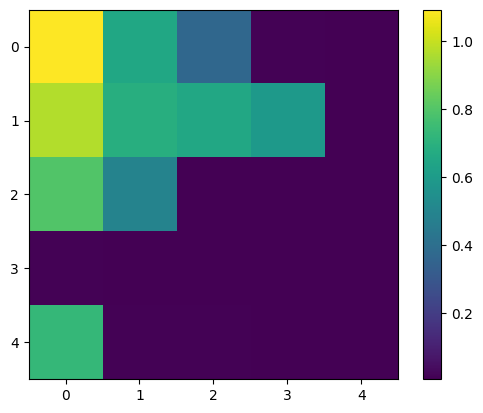

In [4]:
if option == 1:
    B_avg = np.mean(B_hat, axis=0)
    B_sort = np.sort(np.abs(B_avg), axis=1)[:, ::-1]
elif option == 2:
    B_avg = np.mean(np.abs(B_hat), axis=0)
    B_sort = np.sort(B_avg, axis=1)[:, ::-1]

plt.imshow(B_sort)
plt.colorbar()
plt.show()

In [5]:
B_argsort = np.argsort(B_sort, axis=0)
B_argsort

array([[3, 3, 2, 3, 3],
       [4, 4, 3, 2, 0],
       [2, 2, 4, 4, 1],
       [1, 0, 0, 0, 4],
       [0, 1, 1, 1, 2]])

In [16]:
order = []
for i in range(p):
    col = B_argsort[:, i]
    available_id = ~np.isin(col, order)
    first_id = np.argmax(available_id)
    order.append(col[first_id])

In [17]:
success = (order == true_order).all()

if success:
    print("The causal order is retrieved!")
else:
    print("The causal order is not retrieved.")

The causal order is retrieved!


# plot obtained matrices B

In [18]:
P = np.eye(p)[order]
B_tilde = P @ B_hat @ P.T

In [19]:
# plot heat maps of causal effect matrices
def heat_maps_B(B, absolute_value=True):
    m, p, _ = B.shape
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    if absolute_value:
        vmin = 0
    else:
        vmin = np.min(B)
    for i, ax in enumerate(axes.flat):
        if absolute_value:
            Bi = np.abs(B[i])
        else:
            Bi = B[i]
        im = ax.imshow(Bi, vmin=vmin, vmax=np.max(B), cmap="copper")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0042, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    if absolute_value:
        title_sup = "(in absolute value)"
    else:
        title_sup = ""
    fig.suptitle(
        f"Causal effect matrices {title_sup} after retrieving permutation P",
        fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.11)
    plt.show()

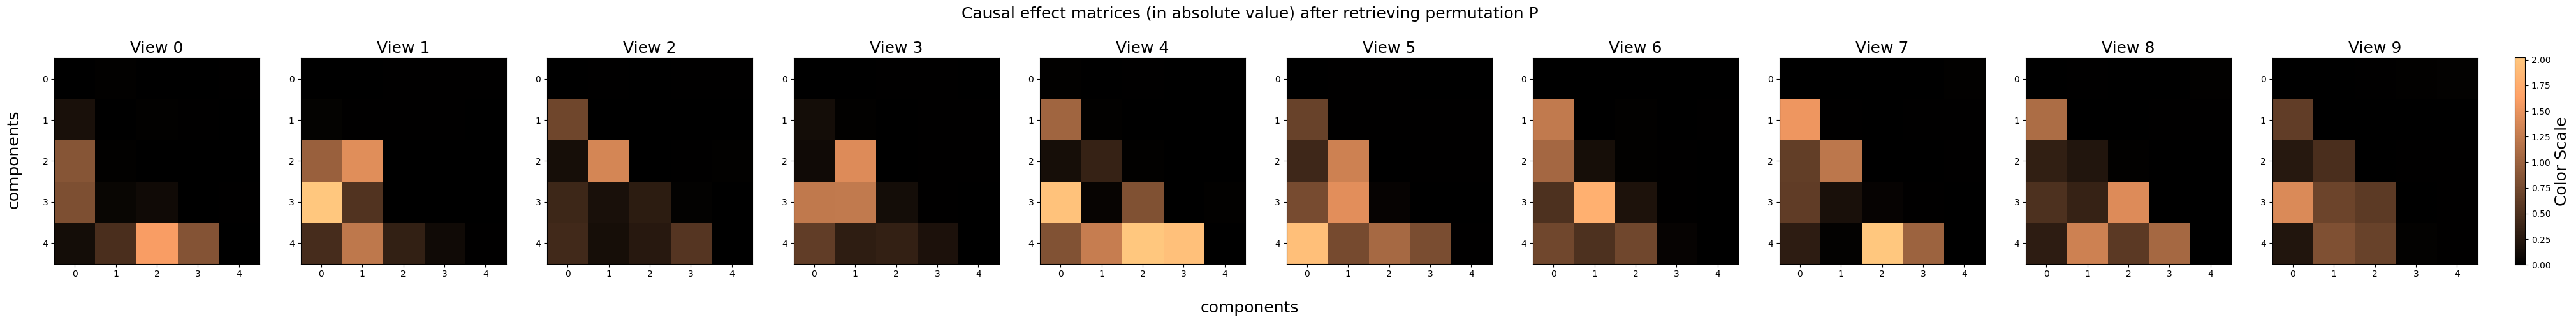

In [20]:
heat_maps_B(B_tilde)

Causal matrices are now strictly lower triangular, as expected!

# compare the 2 options for B_sort

In [11]:
# varying parameters
noise_list = np.logspace(-2, 1, 19)
nb_seeds = 10
random_state_list = np.arange(nb_seeds)

In [12]:
# function that finds P such that P @ B @ P.T is strictly lower triangular
def find_order(B_hat, option=1):
    _, p, _ = B_hat.shape
    if option == 1:
        B_avg = np.mean(B_hat, axis=0)
        B_sort = np.sort(np.abs(B_avg), axis=1)[:, ::-1]
    elif option == 2:
        B_avg = np.mean(np.abs(B_hat), axis=0)
        B_sort = np.sort(B_avg, axis=1)[:, ::-1]
    B_argsort = np.argsort(B_sort, axis=0)
    order = []
    for i in range(p):
        col = B_argsort[:, i]
        available_id = ~np.isin(B_argsort[:, i], order)
        j = 0
        while not available_id[j]:
            j += 1
        order.append(col[j])
    return order

In [13]:
# main function
def run_experiment(noise, random_state, m, p, option=1):
    # sample data
    B_hat, P = sample_data(m, p, noise, np.random.RandomState(random_state))
    true_order = np.argmax(P, axis=1)
    # find order P
    order = find_order(B_hat, option=option)
    # error
    return 1 - (order == true_order).all()

In [14]:
# option 1
results_1 = np.array([
    run_experiment(noise_, random_state_, m, p, option=1)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_1 = results_1.reshape(len(noise_list), len(random_state_list))
error_rate_1 = np.mean(results_1, axis=1)

# option 2
results_2 = np.array([
    run_experiment(noise_, random_state_, m, p, option=2)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_2 = results_2.reshape(len(noise_list), len(random_state_list))
error_rate_2 = np.mean(results_2, axis=1)

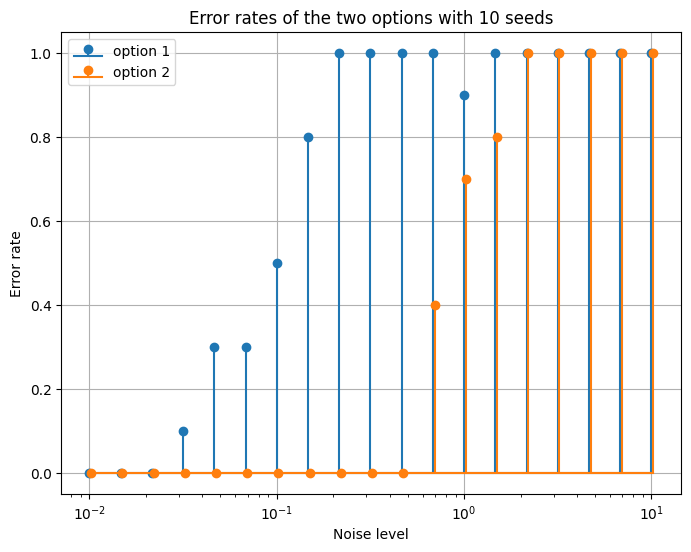

In [15]:
# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# plot rates
plt.figure(figsize=(8, 6))

stem1 = plt.stem(noise_list, error_rate_1, label='option 1')
plt.setp(stem1.markerline, color=colors[0])  # Set marker color
plt.setp(stem1.stemlines, color=colors[0])   # Set stem line color
plt.setp(stem1.baseline, color=colors[0])    # Set baseline color
epsilon = 2 * 1e-2 * noise_list
stem2 = plt.stem(noise_list + epsilon, error_rate_2, label='option 2')
plt.setp(stem2.markerline, color=colors[1])  # Set marker color
plt.setp(stem2.stemlines, color=colors[1])   # Set stem line color
plt.setp(stem2.baseline, color=colors[1])    # Set baseline color

plt.xscale("log")
plt.legend()
plt.title(f"Error rates of the two options with {nb_seeds} seeds")
plt.xlabel("Noise level")
plt.ylabel("Error rate")
plt.grid()
plt.show()

Obviously, the second option (i.e. average of absolute values) is better than the first option (i.e. absolute value of averages) with these data.

In [16]:
id = np.argmax(error_rate_2 != 0)
noise_1 = noise_list[id-1]
noise_2 = noise_list[id]

print(f"The maximum noise level allowed seems to be between {noise_1:.4f} and {noise_2:.4f}.")

The maximum noise level allowed seems to be between 0.4642 and 0.6813.


The function find_order() is a bit naive because it only looks at row permutations (and not column permutations) and because it iterates over the columns instead of doing a global search, but it seems to work.

Moreover, it's starting not to work when the noise level is between 0.46 and 0.68, just as for the linear sum assignment method used in step 2. So, using a more powerful method to find P would only be useful if we also use more powerful method to find Q.